In [1]:
import numpy as np
import pandas as pd
import polars as pl
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from lets_plot import *
LetsPlot.setup_html()

In [2]:
data = pl.read_parquet('../data/dataset_complete_dengue_municipality.parquet')
data = data.with_columns(pl.col('casos').alias('target'))
data = data.with_columns(np.log1p(pl.col('casos')).alias('log_casos'))
data = data.filter(pl.col('uf') != 'ES')

pareto = pl.read_parquet('../data/top_municipalities.parquet')
data = data.join(pareto[['geocode']], on='geocode', how='inner')

In [3]:
enso = pl.read_csv('../../data_sprint_2025/ocean_climate_oscillations.csv.gz')

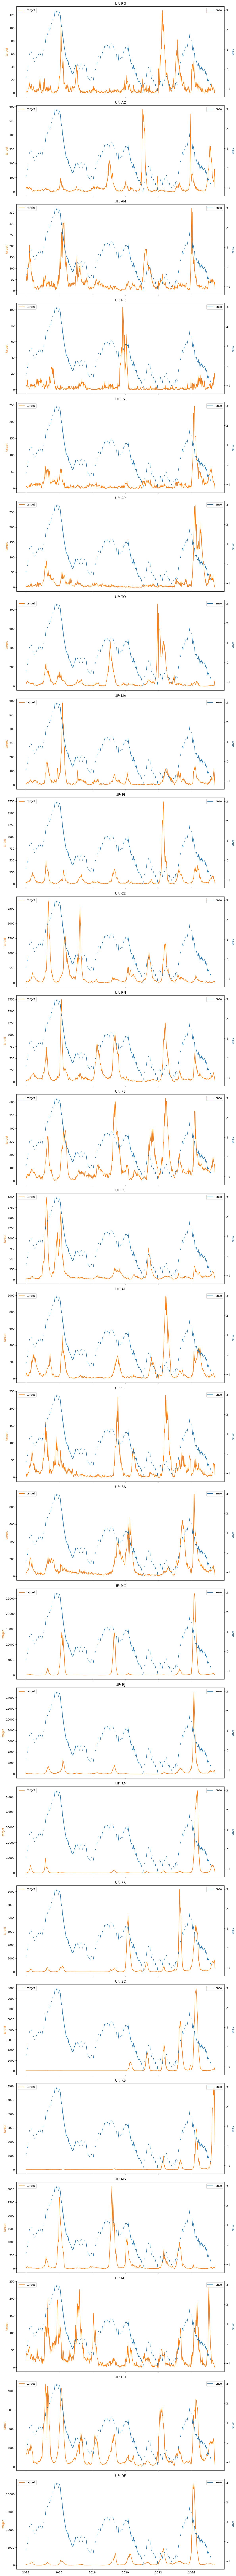

In [10]:
import matplotlib.pyplot as plt

# Prepare data for plotting
# df = data.filter(
#     (pl.col('year') > 2013) & pl.col('uf').is_in(['RJ', 'SC'])
# ).to_pandas()

df = data.filter(
    (pl.col('year') > 2013)
).to_pandas()

ufs = df['uf'].unique()
fig, axes = plt.subplots(len(ufs), 1, figsize=(12, 5 * len(ufs)), sharex=True)

if len(ufs) == 1:
    axes = [axes]

for ax, uf in zip(axes, ufs):
    subdf = df[df['uf'] == uf]
    ax2 = ax.twinx()
    ax.plot(subdf['date'], subdf['target'], color='tab:orange', label='target')
    ax2.plot(subdf['date'], subdf['enso'], color='tab:blue', label='enso')
    ax.set_ylabel('target', color='tab:orange')
    ax2.set_ylabel('enso', color='tab:blue')
    ax.set_title(f'UF: {uf}')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.xlabel('date')
plt.tight_layout()
plt.show()

In [263]:
# data.filter(pl.col('enso').is_not_null())

In [215]:
# data.filter(data['uf']=='RJ')

In [208]:
exo = ['precip_min','precip_max','temp_min','temp_max','pressure_min','pressure_max','population','log_casos']
exo = ['log_casos']
train = data.filter(pl.col('train_3'))[['uf','date','target',*exo]]
train = TimeSeriesDataFrame.from_data_frame(train.to_pandas(),id_column='uf',timestamp_column='date')
test =  data.filter(
    pl.col('target_3') | (
        # ~pl.col('train_1') & 
        (pl.col('date') < np.max(np.array(data.filter(pl.col('target_3')).sort('date')['date'])))
    )
)[['uf','date','target',*exo]]
test = TimeSeriesDataFrame.from_data_frame(test.to_pandas(),id_column='uf',timestamp_column='date')

In [209]:
prediction_length = data.filter('target_3')['epiweek'].unique().shape[0] + data.filter('target_3')['epiweek'].sort()[0] - data.filter('train_3')['epiweek'].sort()[-1]

In [210]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    target="target",
).fit(
    train_data=train,
    hyperparameters={
        "Chronos": [
            {"model_path": "bolt_small", "ag_args": {"name_suffix": "ZeroShot"}},
            # {"model_path": "bolt_small", "fine_tune": True, "ag_args": {"name_suffix": "FineTuned"}},
            # {"model_path": "bolt_small",
            #  "covariate_regressor": "CAT",
            #  "target_scaler": "standard",
            #  "fine_tune": True,
            #  "ag_args": {"name_suffix": "FineTuned-Covariates"}},
        ]
    },
    time_limit=60,  # time limit in seconds
    enable_ensemble=False,
    # presets='fast_training'
)

Beginning AutoGluon training... Time limit = 60s
AutoGluon will save models to '/Users/davibarreira/Documents/DSProjects/Mosqlimate/jbd-mosqlimate-sprint/notebooks/AutogluonModels/ag-20250730_101234'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.5.0: Tue Apr 22 19:54:33 PDT 2025; root:xnu-11417.121.6~2/RELEASE_ARM64_T8122
CPU Count:          8
GPU Count:          0
Memory Avail:       3.73 GB / 16.00 GB (23.3%)
Disk Space Avail:   379.12 GB / 926.35 GB (40.9%)

Fitting with arguments:
{'enable_ensemble': False,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'ZeroShot'},
                                  'model_path': 'bolt_small'}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 50,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 12

In [211]:
predictor.leaderboard(test)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosZeroShot[bolt_small],-2.860907,-0.866699,1.191369,1.721672,0.013892,1


In [212]:
predictions = predictor.predict(train)

Model not specified in predict, will default to the model with the best validation score: ChronosZeroShot[bolt_small]


In [226]:
data.head(1)

date,epiweek,epiweek_yearless,epiyear,week,month,year,geocode,uf,casos,regional_geocode,macroregional_geocode,train_1,target_1,train_2,target_2,train_3,target_3,temp_min,temp_med,temp_max,precip_min,precip_med,precip_max,pressure_min,pressure_med,pressure_max,rel_humid_min,rel_humid_med,rel_humid_max,thermal_range,rainy_days,population,municipality_latitude,municipality_longitude,cope_forecast_temp_med_1,cope_forecast_temp_med_2,cope_forecast_temp_med_3,cope_forecast_temp_med_4,cope_forecast_temp_med_5,cope_forecast_temp_med_6,cope_forecast_umid_med_1,cope_forecast_umid_med_2,cope_forecast_umid_med_3,cope_forecast_umid_med_4,cope_forecast_umid_med_5,cope_forecast_umid_med_6,cope_forecast_precip_tot_1,cope_forecast_precip_tot_2,cope_forecast_precip_tot_3,cope_forecast_precip_tot_4,cope_forecast_precip_tot_5,cope_forecast_precip_tot_6,outlier,season,season_week,enso,iod,pdo,koppen,biome,target,log_casos
datetime[ms],i64,i64,i64,i8,i8,i32,i64,str,i64,i64,i64,bool,bool,bool,bool,bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,str,i64,f64,f64,f64,str,str,i64,f64
2010-01-03 00:00:00,201001,1,2010,53,1,2010,1100205,"""RO""",907,11004,1102,true,false,true,false,true,false,24.019071,26.332771,29.434871,2.0663,23.8635,59.7057,0.979229,0.982157,0.984286,72.882457,86.8142,96.422314,5.4158,7,426558,-63.994606,-8.988166,25.681353,25.940845,25.914604,25.573826,25.255091,25.108673,89.108058,89.299924,89.712047,89.419023,86.26355,78.937533,0.0001238,0.0001241,0.0001218,0.0000863,0.000038,0.0000131,false,"""2009-2010""",64,null,null,null,"""Am""","""Amazônia""",907,6.811244


In [280]:
d1 =(
    ggplot(data=data.filter(pl.col('year')>2013, pl.col('uf').is_in(['RJ','SC'])))
    + geom_line(mapping=aes(x='date',y='enso'),color='blue')
    + facet_grid(y='uf',scales='free_y')
)
d2 =(
    ggplot(data=data.filter(pl.col('year')>2013, pl.col('uf').is_in(['RJ','SC'])))
    + geom_line(mapping=aes(x='date',y='target'),color='blue')
    + facet_grid(y='uf',scales='free_y')
)



In [267]:
(
    ggplot(data=data.filter(pl.col('year')>2013, pl.col('uf').is_in(['RJ','SC'])))
    + geom_line(mapping=aes(x='date',y='target'),color='blue')
    + facet_grid(y='uf',scales='free_y')
)

In [275]:
pred=pl.DataFrame(predictions.reset_index()).rename({'item_id':'uf','timestamp':'date'})
(
    ggplot()
    + geom_line(data=pred, mapping=aes(x='date',y='0.5'))
    + geom_line(data=data.filter(pl.col('year')>2013), mapping=aes(x='date',y='target'),color='blue')
    + facet_grid(y='uf',scales='free_y')
)

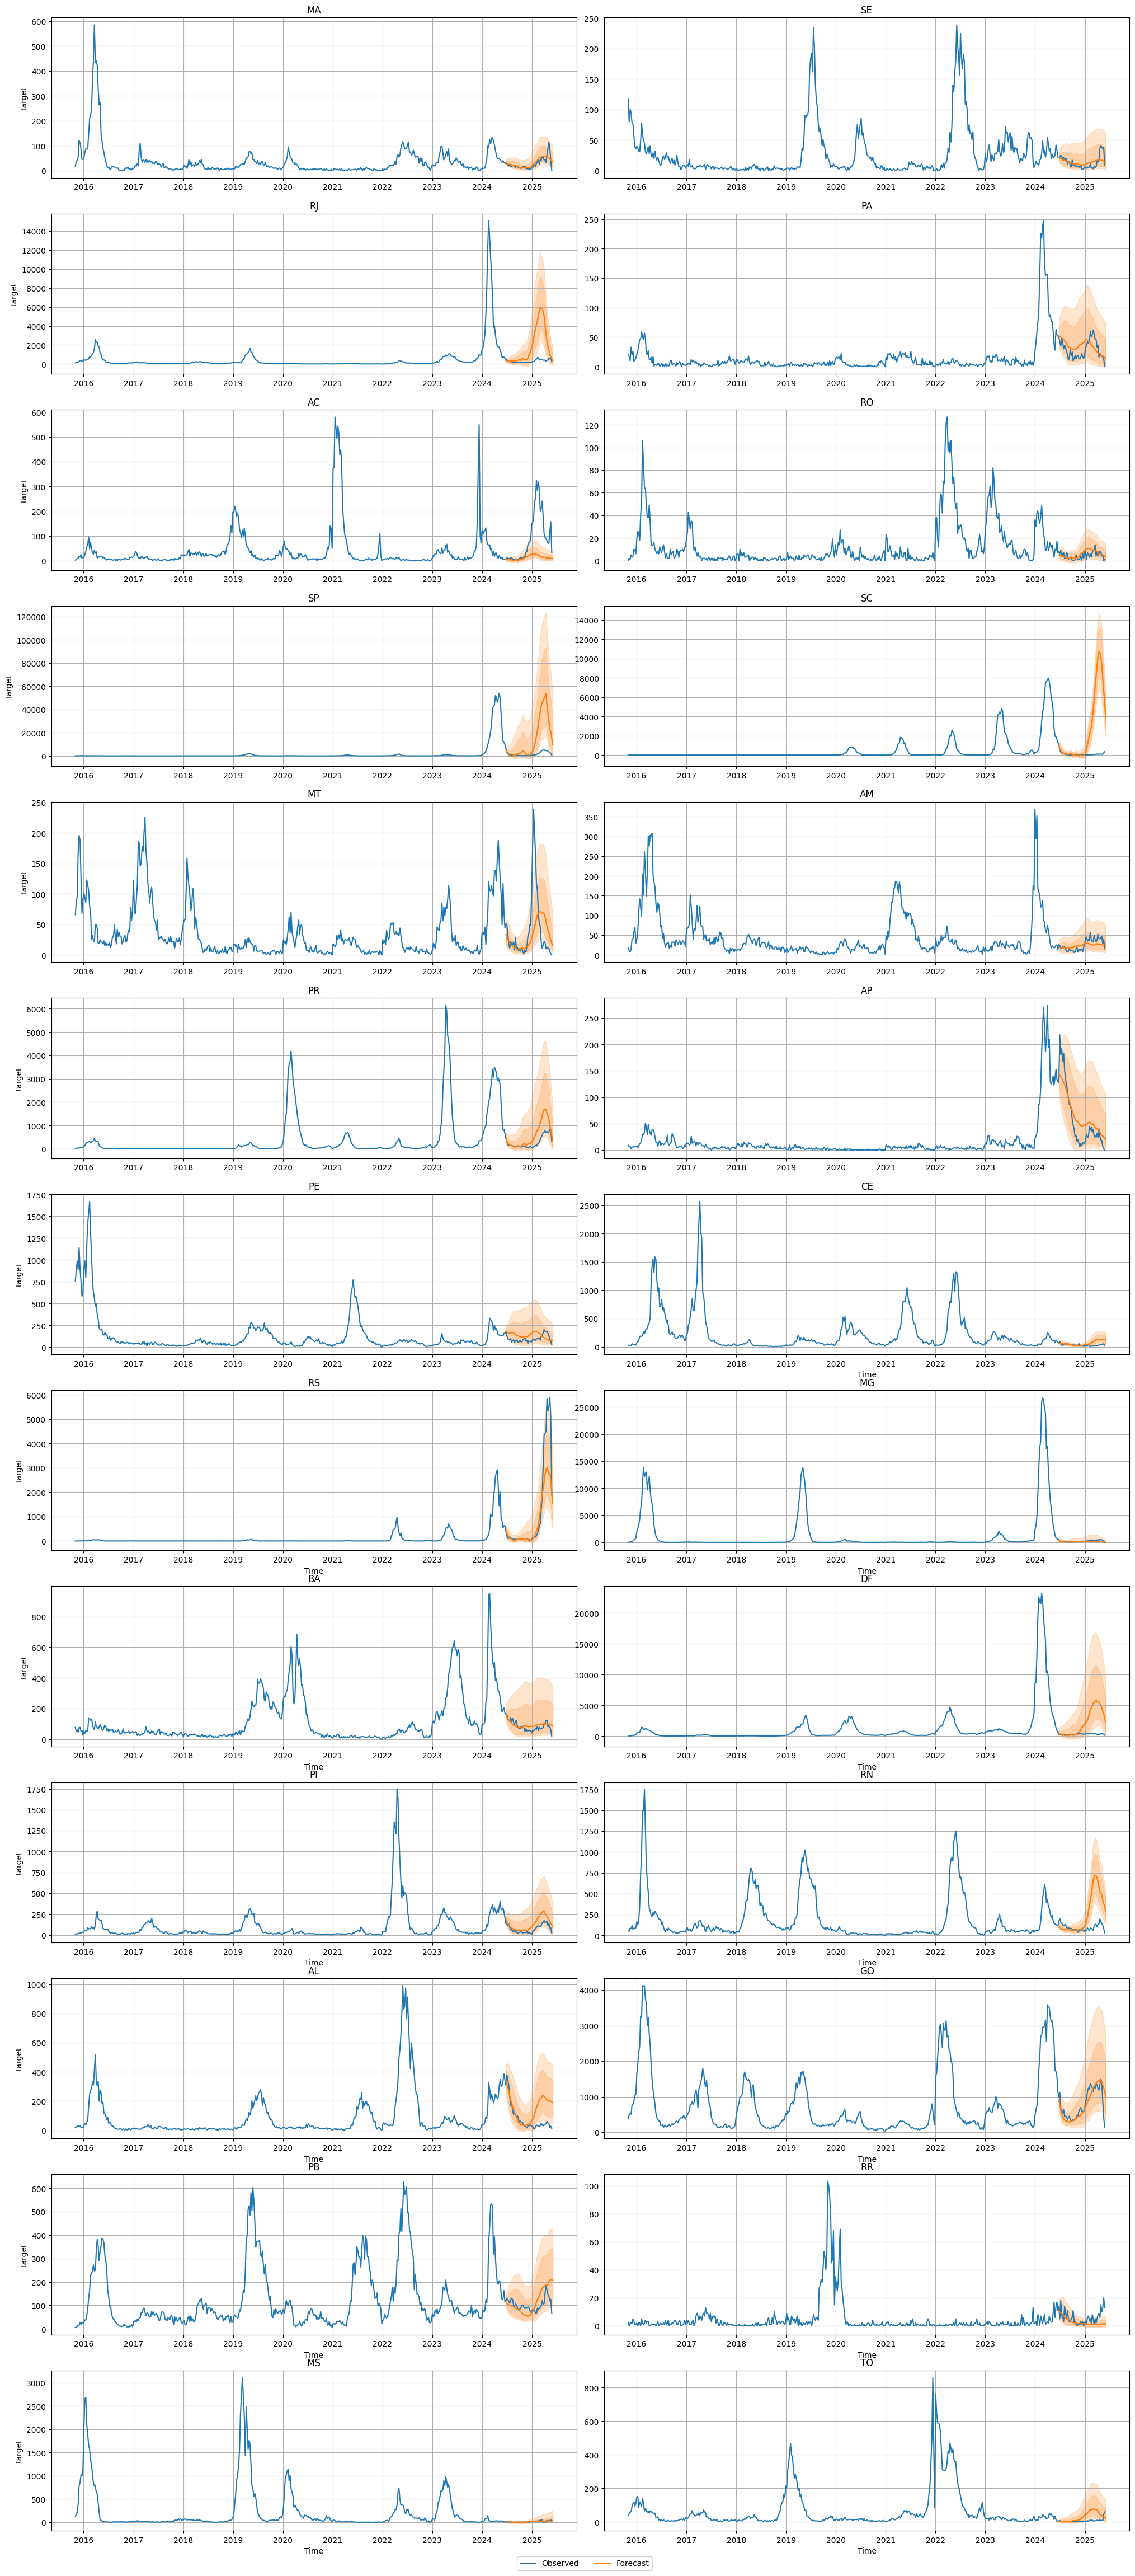

In [203]:
ufs = np.array(data['uf'].unique())
predictor.plot(
    data=test,
    quantile_levels=[0.1,0.2,0.5,0.8,0.9],
    predictions=predictions,
    item_ids = ufs,
    max_num_item_ids=None,
    max_history_length=500,
)